# Оглавление
[Импорт библиотек](#Import) \
[Знакомство с данными](#Glance) \
[Пропроцессинг данных](#Preprocessing) \
[Создание текстовых фичей](#Text) \
[Разведочный анализ данных](#EDA) \
[Разделение на трейн и тест](#Split) \
[Завершение препроцессинга](#Preprocessing_end) \
[Отбор фичей](#Selection) \
[Выбор модели](#Model) \
[Гиперпараметры](#hyperparams) \
[Оценка качества](#quality) \

# Import
Импорт библиотек

In [1]:
pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 8.0 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import chardet # для определения энкодинга
import nltk # пакет работы с текстами
from nltk.sentiment import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, plot_tree

# метрики
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

# отбор фичей
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from scipy import stats

In [5]:
# определим энкодинг, тк при прямом считывании в лоб вылетают ошибки
with open('realty_data.csv', 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
print(result['encoding'])

utf-8


In [6]:
# считываем датасет
# При попытке импорта файла возникают ошибки. Данная конфигурация позволяет импортирвоть файл
# Была убрана только 1 строка Оригинальный размер - 98823, импортированный 98822
df = pd.read_csv('realty_data.csv', encoding='utf-8', on_bad_lines='skip', sep=',',  engine='python')

In [7]:
df.shape

(98822, 17)

# Glance
Первичное знакомство с данными

Описание столбцов:

product_name - наименование объекта недвижимости- \
period - дата \
postcode - почтовый индекс \
address_name - адрес объекта \
lat - координаты (широта) \
lon - координаты (долгота) \
object_type - тип объекта \
total_square - общая площадь \
rooms - количество комнат \
floor - этаж \
city - город \
settlement - населенный пункт \
district - район \
area - микрорайон \
description - текст объявления \
source - источник \

In [ ]:
df.shape

(98822, 17)

In [ ]:
df.head()

,product_name,period,price,postcode,address_name,lat,lon,object_type,total_square,rooms,floor,city,settlement,district,area,description,source
0,"3-комнатная, 137 м²",NaN,63000000,127473.0,"2-й Щемиловский переулок, 5а",55.778894,37.608844,Квартира,137.0,3.0,6.0,Москва,NaN,Тверской район,NaN,Просторная квартира свободной планировки с пан...,ЦИАН
1,"Студия, 16,7 м²",NaN,3250000,108815.0,"Харлампиева, 46",55.551025,37.313054,Квартира,16.7,NaN,1.0,Москва,NaN,Филимонковское поселение,NaN,ВНИМАНИЕ! ОЧЕНЬ ПРИВЛЕКАТЕЛЬНОЕ ПРЕ...,Домклик
2,"3-комнатная, 76 м²",NaN,16004680,NaN,"ЖК Прокшино, 8 к4",55.594802,37.431264,Квартира,76.0,3.0,6.0,Москва,NaN,Сосенское поселение,NaN,"Apт.1684018. 0,01% - гибкая ипотека! Воспользу...",Яндекс.Недвижимость
3,"1-комнатная, 24 м²",NaN,7841776,NaN,"ЖК Прокшино, 6 к2",55.594332,37.428099,Квартира,24.0,1.0,10.0,Москва,NaN,Сосенское поселение,NaN,Продается однокомнатная квартира № 381 в новос...,Новострой-М
4,"3-комнатная, 126 м²",NaN,120000000,121352.0,"Давыдковская, 18",55.721097,37.464342,Квартира,126.0,3.0,16.0,Москва,NaN,Фили-Давыдково район,NaN,Шикарное предложение!\nПродаётся трёхкомнатная...,Домклик


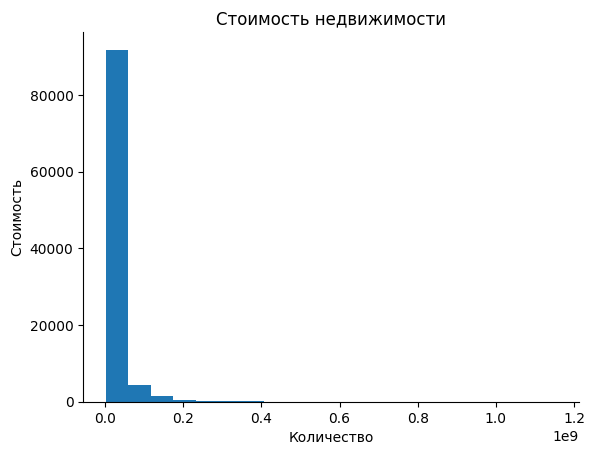

In [ ]:
df['price'].plot(kind='hist', bins=20, title='Стоимость недвижимости')
plt.xlabel('Количество')
plt.ylabel('Стоимость')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# какие города в выборке
df.city.unique()

array(['Москва', nan, 'Балашиха', 'Люберцы', 'Красногорск', 'Химки',
       'Королёв', 'Мытищи', 'Пушкино', 'Котельники', 'Одинцово',
       'Щёлково', 'Дзержинский', 'Реутов', 'Ивантеевка', 'Московский',
       'Лобня', 'Долгопрудный', 'Щербинка', 'Подольск', 'Видное',
       'Лыткарино'], dtype=object)

In [ ]:
# какие источники в выборке
df.source.unique()

array(['ЦИАН', 'Домклик', 'Яндекс.Недвижимость', 'Новострой-М'],
      dtype=object)

# Preprocessing
Пропроцессинг данных \
Обычно я делаю EDA. В данном случае нужно выделить фичи из текста.
По части внесения доп данных из широты и долготы - сложно найти сервис, который бы внес нечто полезное в данные и при этом был бесплатный и был был готов обработать около 100000 записей. Бесплатные сервисы не вносят полезной информации. \
Что рассматривал: \
Яндекс.Карты \
гугл карты \
2гис \
Azure Maps \
MapBox \
DaData \
Бесплатные сервисы могут предоставить полезного только разные государственные коды, такие как ФИАС, КЛАДР, ОКАТО, ОКТМО, ИФНС. При этом, сами по себе они несут маленькую полезность, нужно добывать доплнительные коннекторы, чтобы получить полезные данные, такие как проходимость, рыночная стоимость расстояние от метро, от кольцевой или тип дома. \
Их можно получить только в платных версиях


In [8]:
# выделю размер квартиры через регулярное выражение
df['size'] = df['product_name'].str.extract(r'(\d+,\d+|\d+)\s*м²')[0].str.replace(',', '.').astype(float)

In [9]:
# есть ли ошибки
df['size'].isnull().sum() # ошибок нет

0

In [ ]:
df.head()

,product_name,period,price,postcode,address_name,lat,lon,object_type,total_square,rooms,floor,city,settlement,district,area,description,source,size
0,"3-комнатная, 137 м²",NaN,63000000,127473.0,"2-й Щемиловский переулок, 5а",55.778894,37.608844,Квартира,137.0,3.0,6.0,Москва,NaN,Тверской район,NaN,Просторная квартира свободной планировки с пан...,ЦИАН,137.0
1,"Студия, 16,7 м²",NaN,3250000,108815.0,"Харлампиева, 46",55.551025,37.313054,Квартира,16.7,NaN,1.0,Москва,NaN,Филимонковское поселение,NaN,ВНИМАНИЕ! ОЧЕНЬ ПРИВЛЕКАТЕЛЬНОЕ ПРЕ...,Домклик,16.7
2,"3-комнатная, 76 м²",NaN,16004680,NaN,"ЖК Прокшино, 8 к4",55.594802,37.431264,Квартира,76.0,3.0,6.0,Москва,NaN,Сосенское поселение,NaN,"Apт.1684018. 0,01% - гибкая ипотека! Воспользу...",Яндекс.Недвижимость,76.0
3,"1-комнатная, 24 м²",NaN,7841776,NaN,"ЖК Прокшино, 6 к2",55.594332,37.428099,Квартира,24.0,1.0,10.0,Москва,NaN,Сосенское поселение,NaN,Продается однокомнатная квартира № 381 в новос...,Новострой-М,24.0
4,"3-комнатная, 126 м²",NaN,120000000,121352.0,"Давыдковская, 18",55.721097,37.464342,Квартира,126.0,3.0,16.0,Москва,NaN,Фили-Давыдково район,NaN,Шикарное предложение!\nПродаётся трёхкомнатная...,Домклик,126.0


In [ ]:
# эту переменную можно удалить
df.period.value_counts()

,count
period,


In [10]:
del df['period']

In [11]:
# уникальных значений по комнатности квартиры ограниченное количество
df['product_name'].str.split(',').str[0].unique()

array(['3-комнатная', 'Студия', '1-комнатная', '2-комнатная',
       '4-комнатная', '5-комнатная', 'Квартира', '6-комнатная',
       '10-комнатная', '7-комнатная', '11-комнатная', '8-комнатная',
       '9-комнатная', '12-комнатная', '14-комнатная', '15-комнатная',
       '13-комнатная'], dtype=object)

In [12]:
df['product_name'].isna().sum()

0

In [13]:
# количество комнат
df['rooms'] = df['product_name'].str.extract(r'(\d+)-комнатная')[0].astype(float)
print(df['rooms'].isna().sum()) # проверю что это именно студии

7061


In [ ]:
# попалась квартира без количества комнат
df.loc[pd.isna(df['rooms']), ['rooms', 'product_name']].head()

,rooms,product_name
1,NaN,"Студия, 16,7 м²"
33,NaN,"Студия, 20,6 м²"
39,NaN,"Студия, 35 м²"
41,NaN,"Студия, 20,1 м²"
52,NaN,"Квартира, 40,5 м²"


In [14]:
# выделю только студии
df['flag_studio'] = df['product_name'].str.contains(r'\bСтудия\b')

# сколько будет записей без квадртаного метра и студии
df.loc[pd.isna(df['rooms']) & df['flag_studio'] == True, ['rooms', 'product_name']].shape
# значит количество настоящих пустых значений - 7061 - 6409 = 652

(6409, 2)

In [15]:
# Пусть все студии будут считаться, как однокомнатные квартиры
df.loc[pd.isna(df['rooms']) & df['flag_studio'] == True, ['rooms']] = 1

In [16]:
# оставшиеся заполню средним по метражу
avg_size_grouping = df[df['rooms'].notna()].groupby('rooms')['size'].mean()
def find_nearest_rooms(size):
    return avg_size_grouping.index[np.abs(avg_size_grouping - size).argmin()]

df.loc[pd.isna(df['rooms']), 'rooms'] = df.loc[pd.isna(df['rooms']), 'size'].apply(find_nearest_rooms)

In [ ]:
# проверим количество незаполненных значений
df['rooms'].isna().sum() # все ок

0

In [17]:
# удалю промежуточные и ненужные колонки
df = df.drop(columns=['product_name', 'flag_studio', 'lat', 'lon'], axis=1)

In [ ]:
df.head()

,price,postcode,address_name,object_type,total_square,rooms,floor,city,settlement,district,area,description,source,size
0,63000000,127473.0,"2-й Щемиловский переулок, 5а",Квартира,137.0,3.0,6.0,Москва,NaN,Тверской район,NaN,Просторная квартира свободной планировки с пан...,ЦИАН,137.0
1,3250000,108815.0,"Харлампиева, 46",Квартира,16.7,1.0,1.0,Москва,NaN,Филимонковское поселение,NaN,ВНИМАНИЕ! ОЧЕНЬ ПРИВЛЕКАТЕЛЬНОЕ ПРЕ...,Домклик,16.7
2,16004680,NaN,"ЖК Прокшино, 8 к4",Квартира,76.0,3.0,6.0,Москва,NaN,Сосенское поселение,NaN,"Apт.1684018. 0,01% - гибкая ипотека! Воспользу...",Яндекс.Недвижимость,76.0
3,7841776,NaN,"ЖК Прокшино, 6 к2",Квартира,24.0,1.0,10.0,Москва,NaN,Сосенское поселение,NaN,Продается однокомнатная квартира № 381 в новос...,Новострой-М,24.0
4,120000000,121352.0,"Давыдковская, 18",Квартира,126.0,3.0,16.0,Москва,NaN,Фили-Давыдково район,NaN,Шикарное предложение!\nПродаётся трёхкомнатная...,Домклик,126.0


Почтовые индексы России состоят исключительно из шести цифр XXXYYY, где XXX – код города, а YYY — номер почтового отделения. В некоторых особенно крупных городах введено несколько кодов. Например, это правило действует для индекса Москвы. Далее к коду добавляется номер почтового отделения.
Вывод - почтовый индекс не принесет новой полезной инфорамции. Единственное, что могу учесть - это факт наличия пустоты.

In [18]:
df['flag_postcode'] = df['postcode'].isna()
df['flag_postcode'].fillna(False, inplace=True)
df = df.drop(columns=['postcode'], axis=1)

In [ ]:
df.isna().sum() # в общем проусков мало, больше всех в поселении, потому что там деревни и зоне

,0
price,0
address_name,1
object_type,0
total_square,0
rooms,0
floor,0
city,6894
settlement,91928
district,23711
area,79324


In [19]:
# из адреса можно выделить только тип - улица, проспект, другое, что может говорить об оживленности в районе
# потенциально уровень коммерциализации, зашумленности, развития. Хотя в большинстве адресов не указан тип
df['flag_bulvar'] = df['address_name'].str.contains(r'\b[Б|б]ульвар\b').fillna(False)
df['flag_prospect'] = df['address_name'].str.contains(r'\b[П|п]роспект\b').fillna(False)
df['flag_ulitsa'] = df['address_name'].str.contains(r'\b[У|у]лица\b').fillna(False)
df['flag_shosse'] = df['address_name'].str.contains(r'\b[Ш|ш]оссе\b').fillna(False)
df['flag_proezd'] = df['address_name'].str.contains(r'\b[П|п]роезд\b').fillna(False)
df['flag_ZK'] = df['address_name'].str.contains(r'\bЖК\b').fillna(False)
df['flag_drugoe'] = (~df['flag_bulvar'] & ~df['flag_prospect'] & ~df['flag_ulitsa'] & ~df['flag_shosse'] & ~df['flag_proezd'] & ~df['flag_ZK'])

In [20]:
df = df.drop(columns=['address_name'], axis=1)

In [ ]:
df.head()

,price,object_type,total_square,rooms,floor,city,settlement,district,area,description,source,size,flag_postcode,flag_bulvar,flag_prospect,flag_ulitsa,flag_shosse,flag_proezd,flag_ZK,flag_drugoe
0,63000000,Квартира,137.0,3.0,6.0,Москва,NaN,Тверской район,NaN,Просторная квартира свободной планировки с пан...,ЦИАН,137.0,False,False,False,False,False,False,False,True
1,3250000,Квартира,16.7,1.0,1.0,Москва,NaN,Филимонковское поселение,NaN,ВНИМАНИЕ! ОЧЕНЬ ПРИВЛЕКАТЕЛЬНОЕ ПРЕ...,Домклик,16.7,False,False,False,False,False,False,False,True
2,16004680,Квартира,76.0,3.0,6.0,Москва,NaN,Сосенское поселение,NaN,"Apт.1684018. 0,01% - гибкая ипотека! Воспользу...",Яндекс.Недвижимость,76.0,True,False,False,False,False,False,True,False
3,7841776,Квартира,24.0,1.0,10.0,Москва,NaN,Сосенское поселение,NaN,Продается однокомнатная квартира № 381 в новос...,Новострой-М,24.0,True,False,False,False,False,False,True,False
4,120000000,Квартира,126.0,3.0,16.0,Москва,NaN,Фили-Давыдково район,NaN,Шикарное предложение!\nПродаётся трёхкомнатная...,Домклик,126.0,False,False,False,False,False,False,False,True


In [21]:
print(df['object_type'].unique())
df = df.drop(columns=['object_type'], axis=1) # только 1 тип данных. Полезной информации не несет

['Квартира']


In [ ]:
df.isna().sum()

,0
price,0
total_square,0
rooms,0
floor,0
city,6894
settlement,91928
district,23711
area,79324
description,249
source,0


In [ ]:
df.head()

,price,total_square,rooms,floor,city,settlement,district,area,description,source,size,flag_postcode,flag_bulvar,flag_prospect,flag_ulitsa,flag_shosse,flag_proezd,flag_ZK,flag_drugoe
0,63000000,137.0,3.0,6.0,Москва,NaN,Тверской район,NaN,Просторная квартира свободной планировки с пан...,ЦИАН,137.0,False,False,False,False,False,False,False,True
1,3250000,16.7,1.0,1.0,Москва,NaN,Филимонковское поселение,NaN,ВНИМАНИЕ! ОЧЕНЬ ПРИВЛЕКАТЕЛЬНОЕ ПРЕ...,Домклик,16.7,False,False,False,False,False,False,False,True
2,16004680,76.0,3.0,6.0,Москва,NaN,Сосенское поселение,NaN,"Apт.1684018. 0,01% - гибкая ипотека! Воспользу...",Яндекс.Недвижимость,76.0,True,False,False,False,False,False,True,False
3,7841776,24.0,1.0,10.0,Москва,NaN,Сосенское поселение,NaN,Продается однокомнатная квартира № 381 в новос...,Новострой-М,24.0,True,False,False,False,False,False,True,False
4,120000000,126.0,3.0,16.0,Москва,NaN,Фили-Давыдково район,NaN,Шикарное предложение!\nПродаётся трёхкомнатная...,Домклик,126.0,False,False,False,False,False,False,False,True


In [22]:
# Предлагаю сделать группировку по локации, используя субьективные знания о мире :)
def get_location_category(df: pd.DataFrame):
  if df['city'] == 'Москва':
    return 1
  elif df['city'] in ['Балашиха', 'Люберцы', 'Красногорск', 'Химки', 'Мытищи',
                      'Котельники', 'Одинцово','Дзержинский', 'Реутов', 'Московский','Долгопрудный']:
    return 2
  elif df['city'] in ['Щёлково', 'Королёв', 'Щербинка', 'Подольск', 'Видное', 'Лыткарино', 'Пушкино',
                      'Ивантеевка', 'Лобня']:
    return 3
  elif pd.notna(df['settlement']):
    return 4
  else:
    return 5

df['location_category'] = df[['settlement', 'city']].apply(get_location_category, axis=1)

In [23]:
# теперь обращу внимание на тип поселения settlement
# тут значения либо nan либо имя поселка. Имя мне ни о чем не говорит. Предлагаю их объединить районы Москвы
# и названия поселков, так что получится получить некоторые средние по району или поселку, потом можно
# будет дальше вычислить отношения между ними
df['district'].fillna(df['settlement'], inplace=True)

# удаление колонки, которая не пригодится в будущем
df = df.drop(columns=['settlement'], axis=1)

In [24]:
# Введем понятие квадратного метра
df['square_meter'] = df['total_square'] / df['rooms']

# И стоимости квадратного метра
# Решил убрать этот показатель, потому что это дает слишком большую подсказку модели. Цена - это тарегет
# df['price_square_meter'] = df['price'] / df['total_square']

In [25]:
# size колонка получилась лишней, есть total_square
df.drop(columns=['size'], inplace=True)

# по колонке 'area' - слишком много пропусков и слишком трудно их будет сметчить, удаляю
df.drop(columns=['area'], inplace=True)

# также преобразуем таргет, сделав распределение более нормальным, что является необходимым для линейной регрессии
df['log_price'] = np.log(df['price'])

In [26]:
# dummy
df['source'] = df['source'].replace(['ЦИАН', 'Домклик', 'Яндекс.Недвижимость', 'Новострой-М'], ['zian', 'domclick', 'yandex', 'novostroi'])
dummy_variables = pd.get_dummies(df['source'], prefix='source')

# Concatenate dummy variables with original DataFrame
df = pd.concat([df, dummy_variables], axis=1)

# Optionally, drop the original 'source' column
df = df.drop('source', axis=1)


# Text
Обработка и создание текстовых фичей

In [27]:
# количество слов вообще
df['description_count_words'] = df['description'].apply(lambda x: len(str(x).split()) if pd.notna(x) else 0)

# количество слов в верхнем регистре
df['description_count_upper'] = df['description'].apply(lambda x: sum(1 for word in str(x).split() if word.isupper()) if pd.notna(x) else 0)

# количество цифр
df['description_count_digits'] = df['description'].apply(lambda x: sum(1 for char in str(x) if char.isdigit()) if pd.notna(x) else 0)

# количество знаков !
df['description_count_exclamation'] = df['description'].apply(lambda x: str(x).count('!') if pd.notna(x) else 0)

# количество знаков ?
df['description_count_question'] = df['description'].apply(lambda x: str(x).count('?') if pd.notna(x) else 0)

# количество знаков ,
df['description_count_comma'] = df['description'].apply(lambda x: str(x).count(',') if pd.notna(x) else 0)

# количество символов в тексте
df['description_count_symbols'] = df['description'].apply(lambda x: len(str(x)) if pd.notna(x) else 0)

# количество слов в малом регистре
df['description_count_lower'] = df['description'].apply(lambda x: sum(1 for word in str(x).split() if word.islower()) if pd.notna(x) else 0)

# Отношение количества символов к количеству слов
df['description_ratio_symbols_words'] = df['description_count_symbols'] / df['description_count_words']

# отношение количества слов в верхнем регистре к колчеству слов в нижнем регистре
df['description_ratio_upper_lower'] = df['description_count_upper'] / df['description_count_lower']

In [28]:
# В этом тексте есть много работы над поиском именованных сущеностей, различные виды анализа.
# Я использую пакет nltk
nltk.download('vader_lexicon')

def get_sentiment(text):
    if isinstance(text, float):
        text = str(text)

    sia = SentimentIntensityAnalyzer()
    sentiment_scores = sia.polarity_scores(text)

    if sentiment_scores['compound'] >= 0.05:
        return 1
    elif sentiment_scores['compound'] <= -0.05:
        return -1
    else:
        return 0

df['sentiment'] = df['description'].apply(get_sentiment)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [29]:
df['sentiment'].notna().sum() == df.shape[0] # все ок

True

In [30]:
# больше колонка description не пригодится
df.drop(columns=['description'], inplace=True)

# EDA

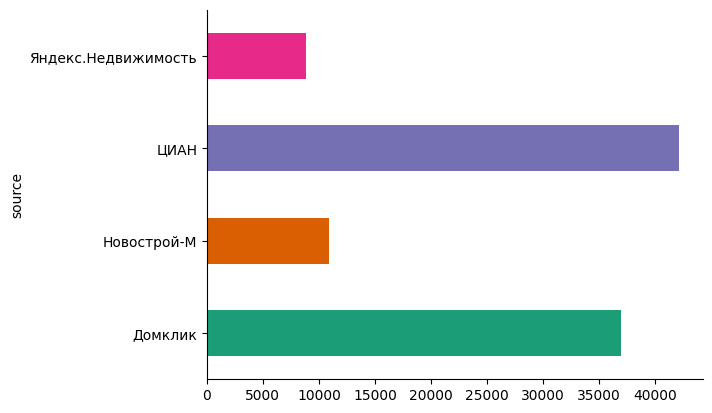

In [ ]:
# визуадихация количества клиентов по источнику
df_tmp = pd.read_csv('realty_data.csv', encoding='utf-8', on_bad_lines='skip', sep=',',  engine='python')
df_tmp.groupby('source').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

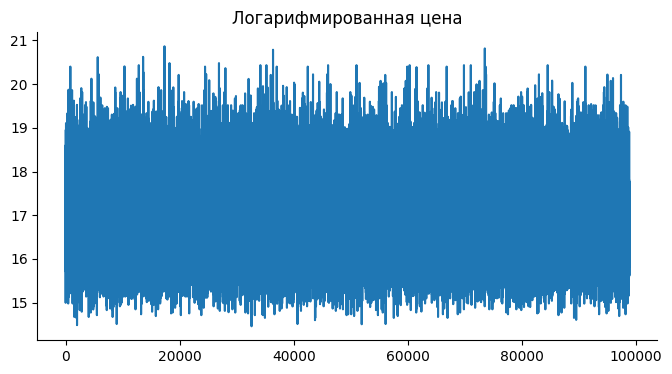

In [ ]:
df['log_price'].plot(kind='line', figsize=(8, 4), title='Логарифмированная цена')
plt.gca().spines[['top', 'right']].set_visible(False)

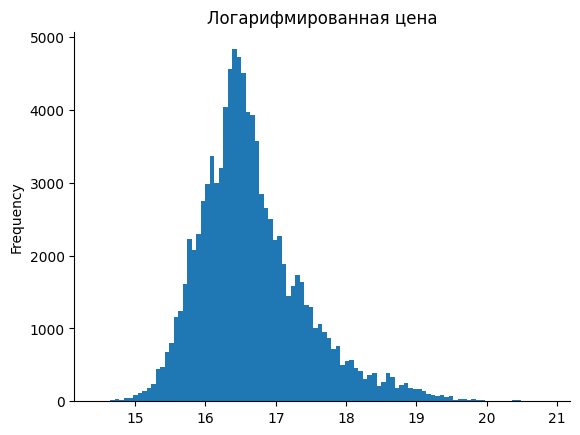

In [ ]:
df['log_price'].plot(kind='hist', bins=100, title='Логарифмированная цена')
plt.gca().spines[['top', 'right',]].set_visible(False)

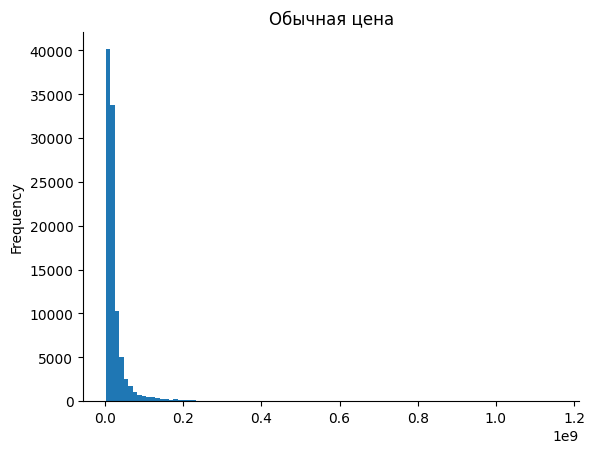

In [ ]:
# распределение очень сдвинуто в сторону хвоста, даже проверять тестом не нужно. Это не нормальное распределение
df['price'].plot(kind='hist', bins=100, title='Обычная цена')
plt.gca().spines[['top', 'right',]].set_visible(False)

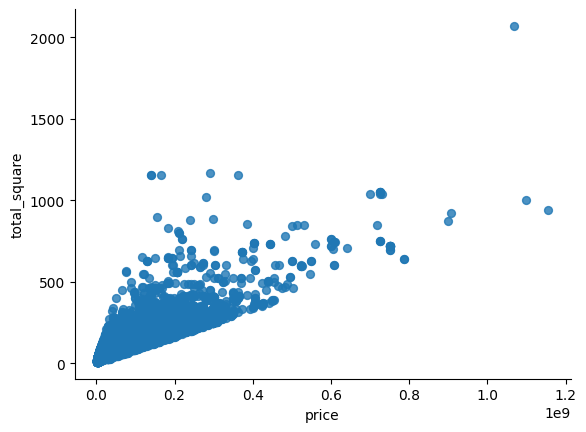

In [40]:
df.plot(kind='scatter', x='price', y='total_square', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [41]:
df.columns

Index(['price', 'total_square', 'rooms', 'floor', 'city', 'district',
       'flag_postcode', 'flag_bulvar', 'flag_prospect', 'flag_ulitsa',
       'flag_shosse', 'flag_proezd', 'flag_ZK', 'flag_drugoe',
       'location_category', 'square_meter', 'log_price', 'source_domclick',
       'source_novostroi', 'source_yandex', 'source_zian',
       'description_count_words', 'description_count_upper',
       'description_count_digits', 'description_count_exclamation',
       'description_count_question', 'description_count_comma',
       'description_count_symbols', 'description_count_lower',
       'description_ratio_symbols_words', 'description_ratio_upper_lower',
       'sentiment'],
      dtype='object')

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector,

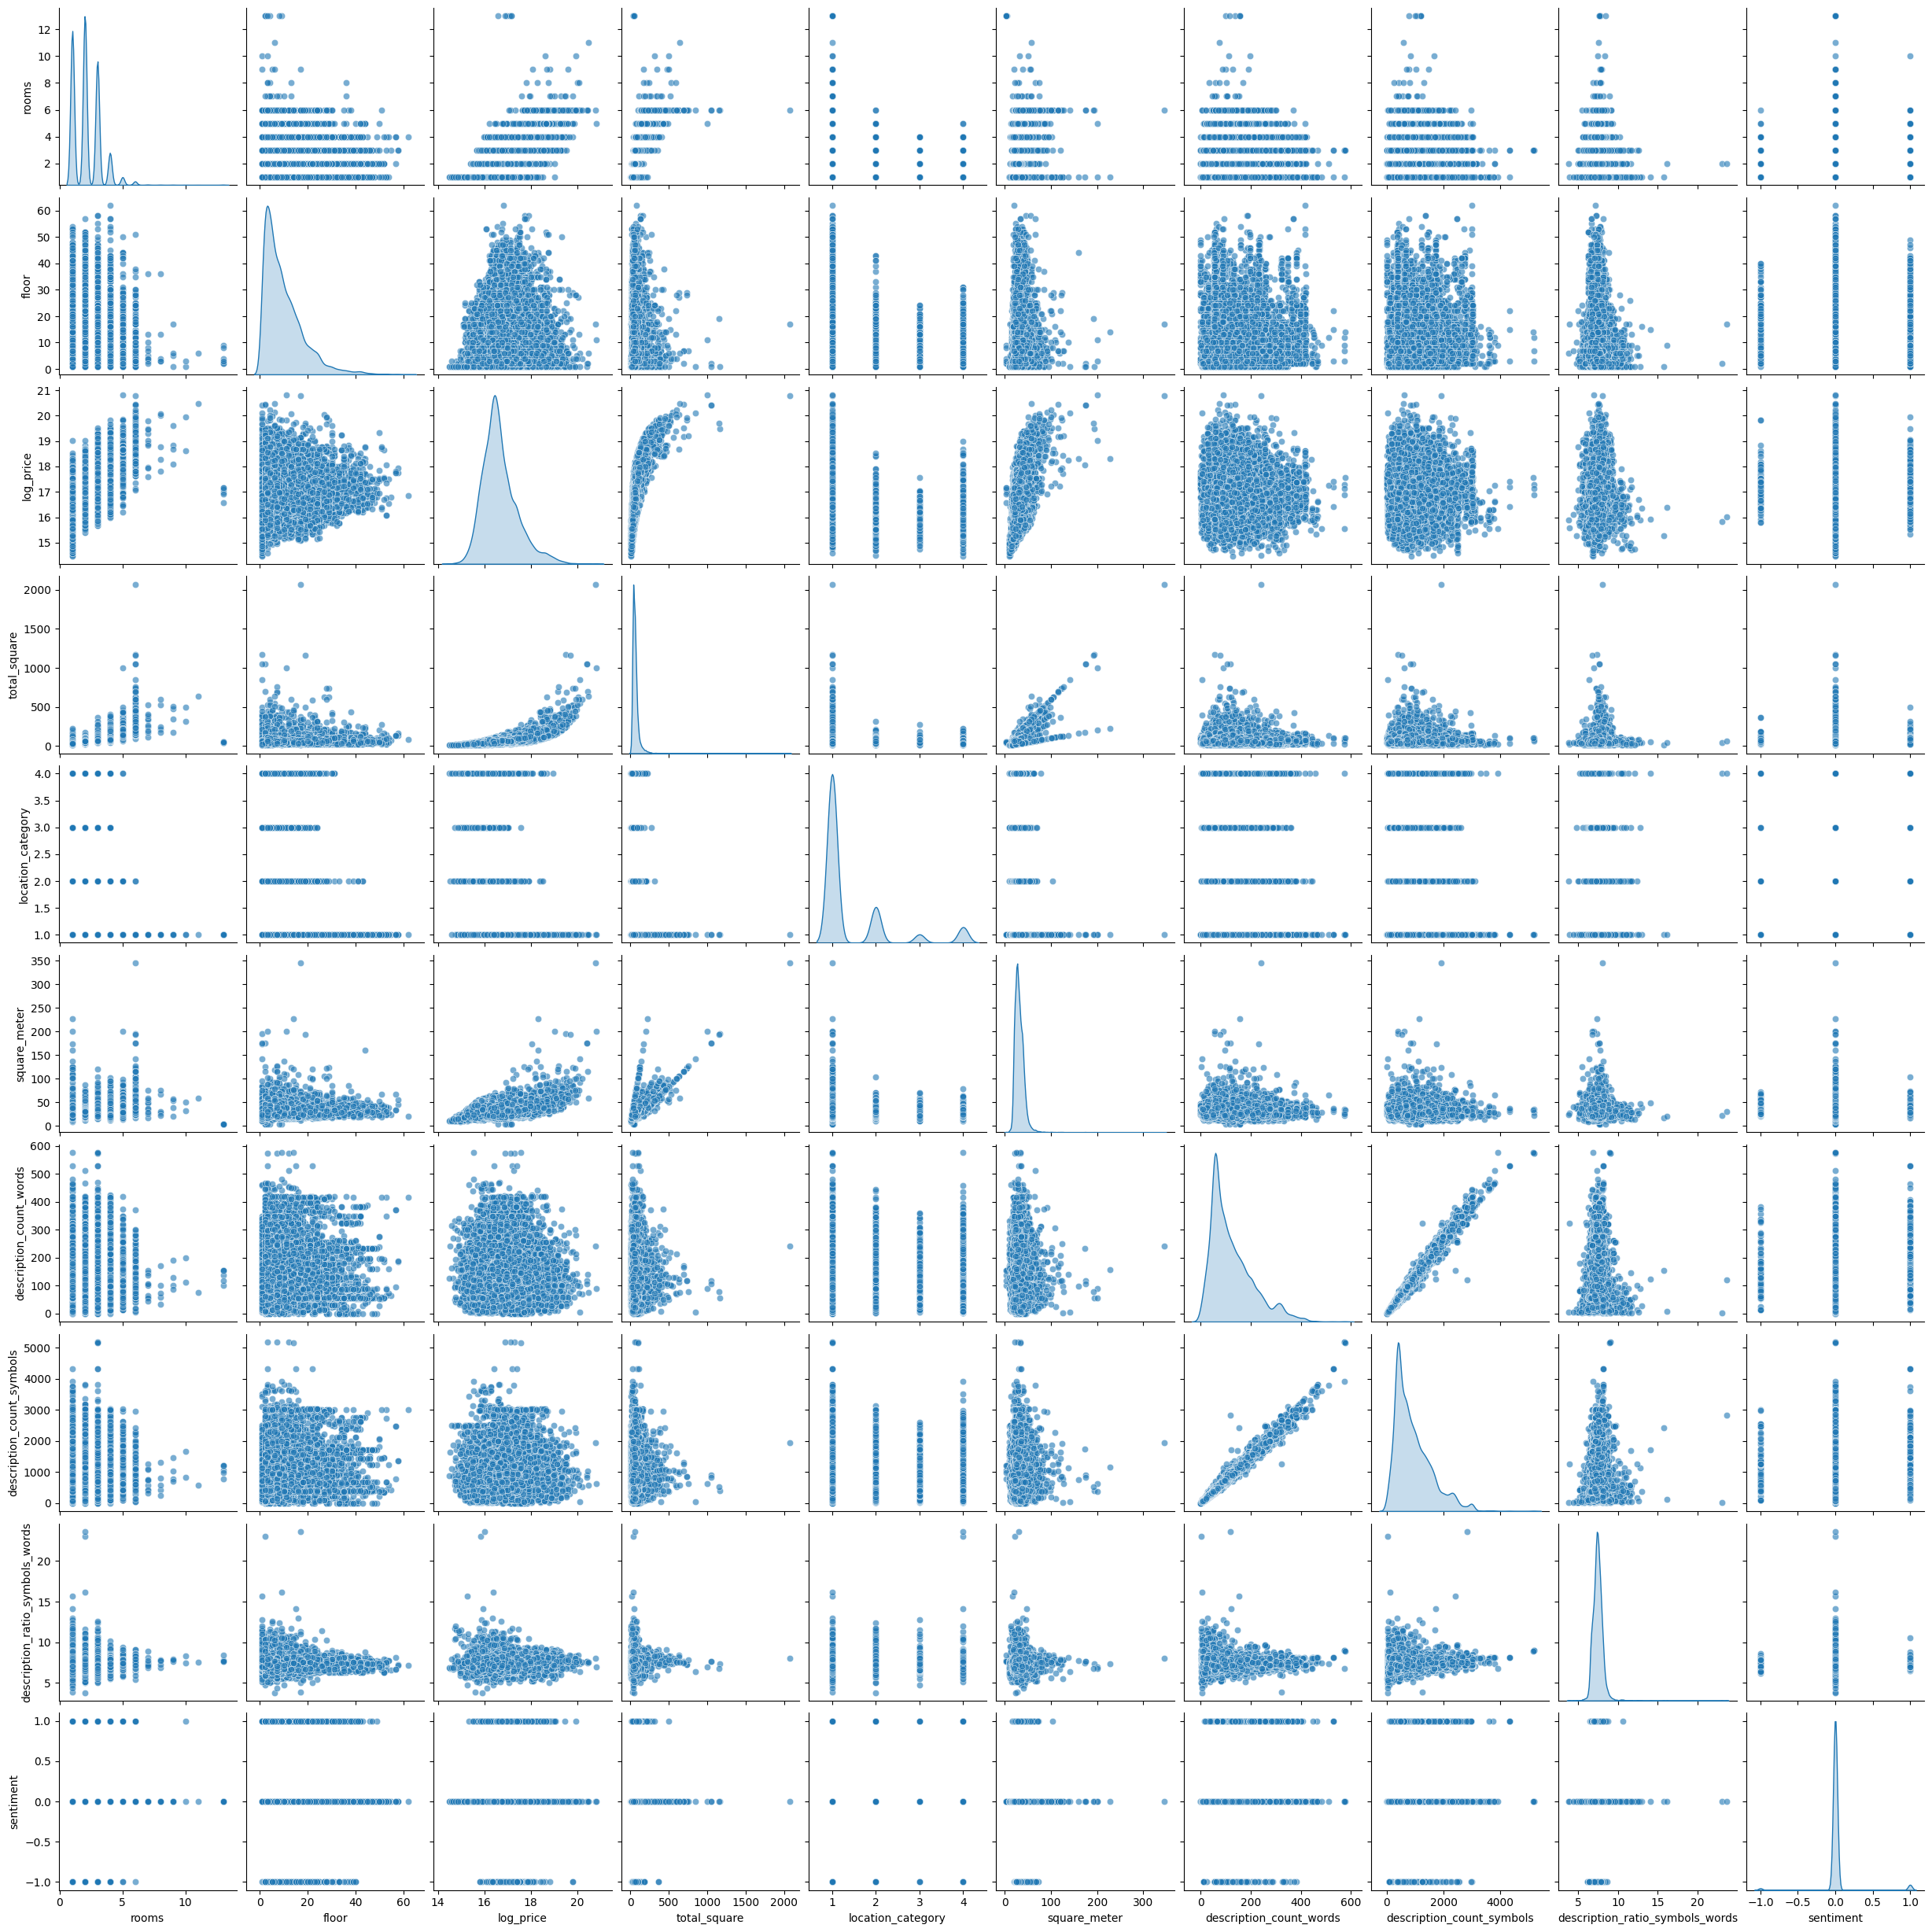

In [34]:
# для более быстрой отрисовки, оставлю только 20000 записей
sample_size = 20000  # или другое подходящее число
df_sample = df.sample(n=sample_size, random_state=42)
sns.pairplot(df_sample,
             vars=['rooms', 'floor', 'log_price','total_square', 'location_category', 'square_meter', 'description_count_words', 'description_count_symbols', 'description_ratio_symbols_words', 'sentiment'],  # выбор конкретных колонок
             kind='scatter',  # тип графика (можно использовать 'reg' для добавления линии регрессии)
             diag_kind='kde',  # тип графика на диагонали ('hist' для гистограммы, 'kde' для графика плотности)
             plot_kws={'alpha': 0.6},  # настройки для scatter plot
             diag_kws={'shade': True})  # настройки для графиков на диагонали

plt.show()

# Split
Разделение на трейн и тест

In [43]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['log_price', 'price']), df['log_price'], test_size=0.2, random_state=42)

# Preprocessing_end
Завершение препроцессинга

In [46]:
# добавлю медиану с группировкой этажности, количеству комнат, общей площади, цене по каждому району Москвы или поселению (где нет района)
# медиана среднего размера комнаты. Оберну в функции, потому что в трейне и тесте будут разные значения
def get_medians_district(df: pd.DataFrame):
  # df['median_district_price'] = df.groupby('district')['price'].transform('median')
  df['median_distict_total_square'] = df.groupby('district')['total_square'].transform('median')
  df['median_distict_rooms'] = df.groupby('district')['rooms'].transform('median')
  df['median_distict_floor'] = df.groupby('district')['floor'].transform('median')
  df['median_district_square_meter'] = df.groupby('district')['square_meter'].transform('median')

In [48]:
# сделаю то же самое по группировке по городу
def get_medians_city(df: pd.DataFrame):
  # df['median_city_price'] = df.groupby('city')['price'].transform('median') # не беру, это таргет
  df['median_city_total_square'] = df.groupby('city')['total_square'].transform('median')
  df['median_city_rooms'] = df.groupby('city')['rooms'].transform('median')
  df['median_city_floor'] = df.groupby('city')['floor'].transform('median')
  df['median_city_square_meter'] = df.groupby('city')['square_meter'].transform('median')

In [49]:
# введу некоторые отношения, которые тоже будут в функции. Поскольку рыночных данных очень мало, я их придумаю
def get_ratios(df: pd.DataFrame):
  # отношение площади квартиры к его
  df['ratio_district_total_square'] = df[['total_square', 'median_distict_total_square']].apply(lambda x: x['total_square'] / x['median_distict_total_square'] if pd.notna(x['total_square']) and pd.notna(x['median_distict_total_square']) and x['median_distict_total_square'] != 0 else 0.0, axis=1)
  df['ratio_city_total_square'] = df[['total_square', 'median_city_total_square']].apply(lambda x: x['total_square'] / x['median_city_total_square'] if pd.notna(x['total_square']) and pd.notna(x['median_city_total_square']) and x['median_city_total_square'] != 0 else 0.0, axis=1)
  df['difference_ratio_total_square'] = (df['ratio_city_total_square'] - df['ratio_district_total_square']).fillna(0)

  # сравнение, насколько данная квартира дороже или дешевле медианы
  # df['ratio_price_district'] = df[['price', 'median_district_price']].apply(lambda x: x['price'] / x['median_district_price'] if pd.notna(x['price']) and pd.notna(x['median_district_price']) and x['median_district_price'] != 0 else 0.0, axis=1)
  # df['ratio_price_city'] = df[['price', 'median_city_price']].apply(lambda x: x['price'] / x['median_city_price'] if pd.notna(x['price']) and pd.notna(x['median_city_price']) and x['median_city_price'] != 0 else 0.0, axis=1)
  # df['difference_ratio_price'] = (df['ratio_price_city'] - df['ratio_price_district']).fillna(0)

  # сравнение по количеству комнат
  df['ratio_rooms_district'] = df[['rooms', 'median_distict_rooms']].apply(lambda x: x['rooms'] / x['median_distict_rooms'] if pd.notna(x['rooms']) and pd.notna(x['median_distict_rooms']) and x['median_distict_rooms'] != 0 else 0.0, axis=1)
  df['ratio_rooms_city'] = df[['rooms', 'median_city_rooms']].apply(lambda x: x['rooms'] / x['median_city_rooms'] if pd.notna(x['rooms']) and pd.notna(x['median_city_rooms']) and x['median_city_rooms'] != 0 else 0.0, axis=1)
  df['difference_ratio_rooms'] = (df['ratio_rooms_city'] - df['ratio_rooms_district']).fillna(0)


In [50]:
# добавлю фичи для трейна и теста отдельно, потому что медианы по показателям могут быть разные
get_medians_district(X_train)
get_medians_city(X_train)
get_ratios(X_train)

get_medians_district(X_test)
get_medians_city(X_test)
get_ratios(X_test)

In [51]:
# важно, чтобы все показатели были числовыми
X_train.select_dtypes(include=['object']).columns

Index(['city', 'district'], dtype='object')

In [52]:
# эти колонки могут больше не пригодиться
X_train.drop(columns=['district', 'city'], axis=1, inplace=True)
X_test.drop(columns=['district', 'city'], axis=1, inplace=True)

In [53]:
# некоторые отношения не посчитались, по ним выпали пустые значения. Заполню их 0
missed = X_train.isna().sum()
missed[missed > 0]

,0
description_ratio_symbols_words,200
description_ratio_upper_lower,205
median_distict_total_square,14214
median_distict_rooms,14214
median_distict_floor,14214
median_district_square_meter,14214
median_city_total_square,5550
median_city_rooms,5550
median_city_floor,5550
median_city_square_meter,5550


In [54]:
# также иногда попадаются очень большие значения
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_train.fillna(0, inplace=True)

X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.fillna(0, inplace=True)

# Selection
Отбор фичей

In [55]:
# сначала я хочу посмотреть на влиятельные фичи с одном дереве, не глубоком, чтобы я мог его визуализировать
regressor = DecisionTreeRegressor(max_depth=3, random_state=42)

# Обучение
regressor.fit(X_train, y_train)

# Получаем важность признаков
feature_importances = pd.Series(regressor.feature_importances_, index=X_train.columns)

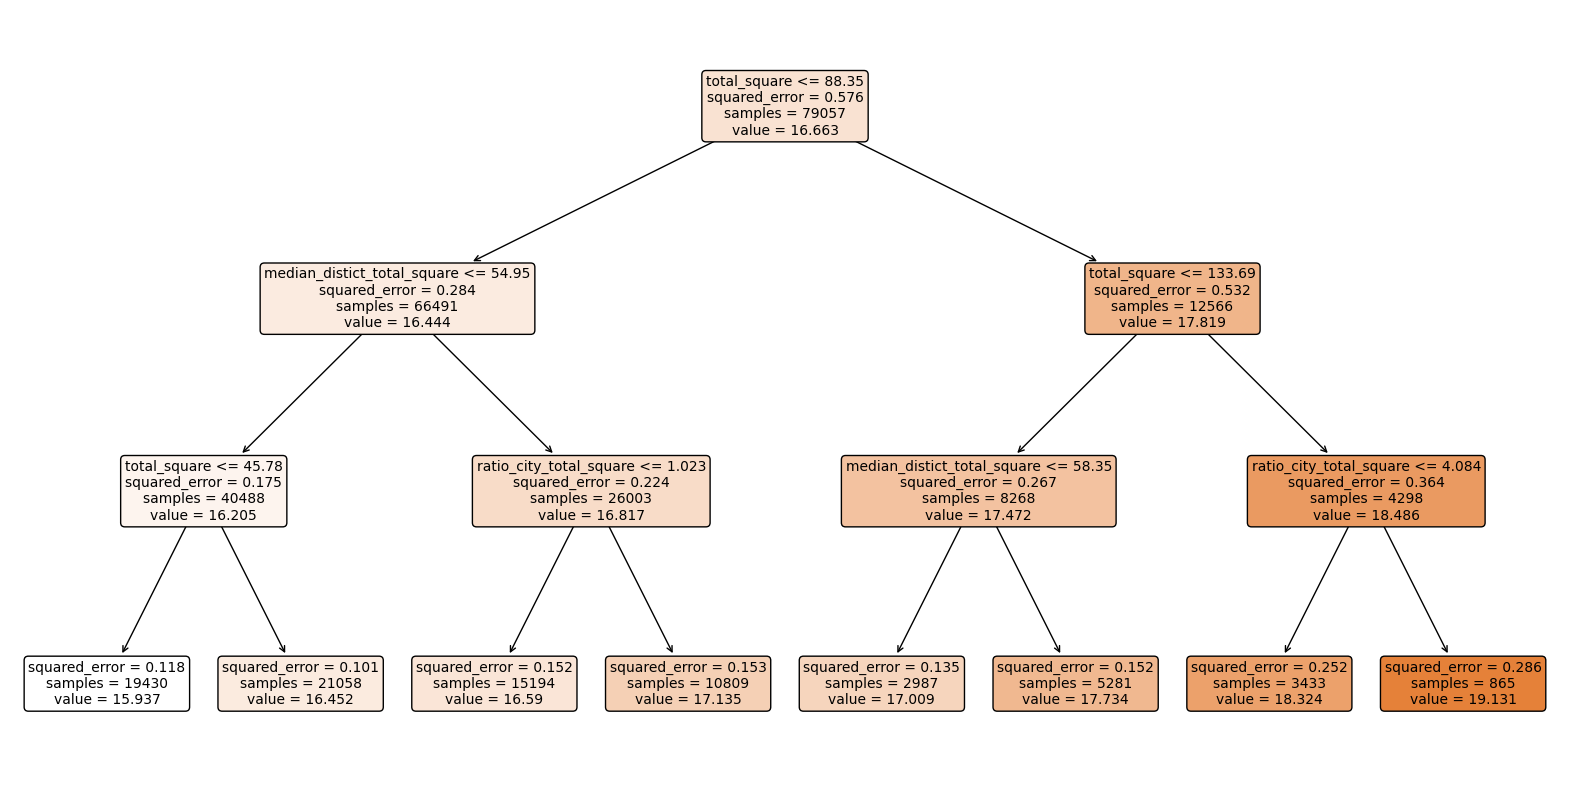

In [56]:
plt.figure(figsize=(20,10))
plot_tree(regressor, feature_names=X_train.columns, filled=True, rounded=True, fontsize=10)
plt.show()

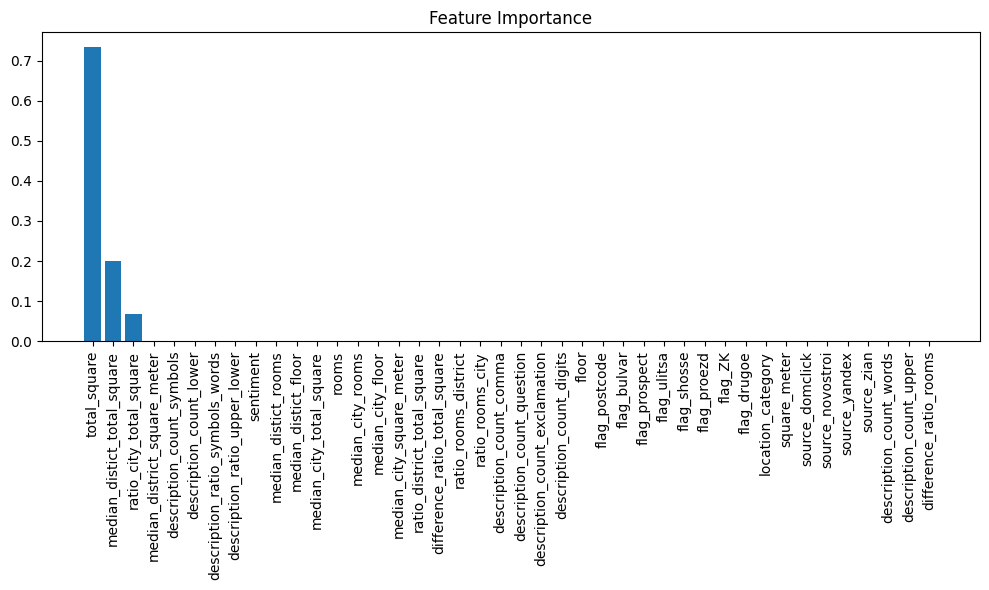

                            feature  importance
0                      total_square    0.734137
1       median_distict_total_square    0.198999
2           ratio_city_total_square    0.066864
3      median_district_square_meter    0.000000
4         description_count_symbols    0.000000
5           description_count_lower    0.000000
6   description_ratio_symbols_words    0.000000
7     description_ratio_upper_lower    0.000000
8                         sentiment    0.000000
9              median_distict_rooms    0.000000
10             median_distict_floor    0.000000
11         median_city_total_square    0.000000
12                            rooms    0.000000
13                median_city_rooms    0.000000
14                median_city_floor    0.000000
15         median_city_square_meter    0.000000
16      ratio_district_total_square    0.000000
17    difference_ratio_total_square    0.000000
18             ratio_rooms_district    0.000000
19                 ratio_rooms_city    0

In [57]:
# явно есть высокий вклад переменных от площади
feature_importance = pd.DataFrame({'feature': X_train.columns, 'importance': regressor.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False).reset_index(drop=True)

plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.xticks(rotation=90)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

print(feature_importance)

In [58]:
# фукнция для получения метрик
def get_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    evs = explained_variance_score(y_true, y_pred)

    print("Regression Metrics:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-squared (R2) Score: {r2:.4f}")
    print(f"Explained Variance Score: {evs:.4f}")

    return mse, rmse, mae, r2

In [59]:
# посмотрю на качество этого дерева. Буду считать это беслайном
y_pred = regressor.predict(X_test)
baseline_mse, baseline_rmse, baseline_mae, baseline_r2 = get_metrics(y_test, y_pred)

Regression Metrics:
Mean Squared Error (MSE): 0.1402
Root Mean Squared Error (RMSE): 0.3745
Mean Absolute Error (MAE): 0.2939
R-squared (R2) Score: 0.7574
Explained Variance Score: 0.7574


In [60]:
# общее количество фичей
X_train.shape

(79057, 42)

## VarianceThreshold

In [61]:
# предлагаю посмотреть сначала какую дисперсию они описывают
threshold = 0.0  # Хочу посмотреть все фичи
selector = VarianceThreshold(threshold=threshold)

selector.fit(X_train)
variances = selector.variances_

variance = pd.DataFrame({'Feature': X_train.columns, 'Variance': variances})
variance_sorted = variance.sort_values(by='Variance')

print(variance_sorted[:10])

                          Feature  Variance
26  description_ratio_upper_lower  0.005678
21     description_count_question  0.018547
4                     flag_bulvar  0.039860
27                      sentiment  0.040364
9                         flag_ZK  0.042888
3                   flag_postcode  0.049534
7                     flag_shosse  0.055883
8                     flag_proezd  0.070156
5                   flag_prospect  0.076694
15                  source_yandex  0.081753


In [62]:
# готов удалить description_ratio_upper_lower и description_count_question
# остальные могут быть полезны, а флаги редко несут высокую дисперсию. Посмотрю, как покажут себя в других методах
X_train.drop(columns=['description_ratio_upper_lower', 'description_count_question'], inplace=True)
X_test.drop(columns=['description_ratio_upper_lower', 'description_count_question'], inplace=True)

## mutual_info_regression

In [63]:
mi = mutual_info_regression(X_train, y_train)
mi_df = pd.DataFrame({'Feature': X_train.columns, 'Mutual Information': mi})

In [64]:
mi_df_sort = mi_df.sort_values(by='Mutual Information', ascending=True)
mi_df_sort.head(10)

,Feature,Mutual Information
4,flag_bulvar,0.007295
7,flag_shosse,0.008701
5,flag_prospect,0.021188
8,flag_proezd,0.026092
25,sentiment,0.028716
6,flag_ulitsa,0.030896
3,flag_postcode,0.043913
10,flag_drugoe,0.048738
31,median_city_rooms,0.049010
20,description_count_exclamation,0.053914


In [65]:
# сентимент я хочу оставить, потому что все такие возможно он будет полезен.
# Остальные фичи убираю, с самой низкой общей информацией
mi_for_elimination = mi_df_sort[mi_df_sort.index != 25].iloc[:7]
mi_for_elimination

,Feature,Mutual Information
4,flag_bulvar,0.007295
7,flag_shosse,0.008701
5,flag_prospect,0.021188
8,flag_proezd,0.026092
6,flag_ulitsa,0.030896
3,flag_postcode,0.043913
10,flag_drugoe,0.048738


In [66]:
X_train.drop(columns=mi_for_elimination.Feature.values.tolist(), inplace=True)
X_test.drop(columns=mi_for_elimination.Feature.values.tolist(), inplace=True)

In [67]:
X_train.shape

(79057, 33)

## Random forest feature importance

In [68]:
rf_regressor = RandomForestRegressor(n_estimators=200, random_state=42)
# чем больше деревьев, тем как правило выше точность, снижается дисперсия. Я бы поставил на тысячу или больше, но очень долго считается
rf_regressor.fit(X_train, y_train)

importances = rf_regressor.feature_importances_

importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'impotance': importances
})

importance_df_sorted = importance_df.sort_values(by='impotance', ascending=False)
print(importance_df_sorted)

                            feature  impotance
0                      total_square   0.597554
19      median_distict_total_square   0.162118
28          ratio_city_total_square   0.070230
29    difference_ratio_total_square   0.030986
23         median_city_total_square   0.024201
4                 location_category   0.019616
22     median_district_square_meter   0.013042
5                      square_meter   0.010774
2                             floor   0.009837
9                       source_zian   0.008591
21             median_distict_floor   0.007290
17  description_ratio_symbols_words   0.006738
27      ratio_district_total_square   0.005865
12         description_count_digits   0.004709
14          description_count_comma   0.004258
15        description_count_symbols   0.004106
16          description_count_lower   0.003703
11          description_count_upper   0.003548
6                   source_domclick   0.003204
10          description_count_words   0.002733
13    descrip

In [69]:
# уберу худшие 11 фичей
X_train.drop(columns=importance_df_sorted.iloc[-11:].feature.values.tolist(), inplace=True)
X_test.drop(columns=importance_df_sorted.iloc[-11:].feature.values.tolist(), inplace=True)

# Оптимальное количество признаков

In [70]:
all_features = X_train.columns.tolist()

def evaluate_model(n_features, X, y):
    # использую модель LGBMRegressor, она быстрее работает
    model = lgb.LGBMRegressor(
        n_estimators=30, # небольшое количество, чтобы не было оверфиттинга и долго не считалось
        learning_rate=0.1,
        objective='regression'
    )

    selected_features = all_features[:n_features]
    X_subset = X[selected_features]

    scores = cross_val_score(model, X_subset, y, cv=5, scoring='neg_root_mean_squared_error')

    # Пусть метрикой будет RMSE
    return -scores.mean()

# Определяем диапазон количества признаков для проверки
max_features = len(all_features)
step = 3
rmse_score_crossval = []

# создам валидационный сет и трейнового
X_train_tmp, X_val, y_train_tmp, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Оценка для различного числа признаков
for n_features in range(step, max_features + 1, step):
    score = evaluate_model(n_features, X_val, y_val) #
    rmse_score_crossval.append((n_features, score))
    print(f"Features: {n_features}, RMSE: {score:.4f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 315
[LightGBM] [Info] Number of data points in the train set: 12649, number of used features: 3
[LightGBM] [Info] Start training from score 16.658299
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315
[LightGBM] [Info] Number of data points in the train set: 12649, number of used features: 3
[LightGBM] [Info] Start training from score 16.661052
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 316
[LightGBM] [Info] Number of data points in the train set: 1

In [71]:
# значит достаточно 18 фичей
rmse_score_crossval

[(3, 0.29944761009466764),
 (6, 0.27941467770466955),
 (9, 0.27247496971141916),
 (12, 0.2702237552714535),
 (15, 0.26788073438294446),
 (18, 0.21380116920153167),
 (21, 0.21103863103670933)]

In [72]:
# удалю лишние признаки через известный лес. Оставлю 18 лучших признаков
X_train = X_train[importance_df_sorted[:18].feature.values.tolist()]
X_test = X_test[importance_df_sorted[:18].feature.values.tolist()]

In [73]:
X_train.shape

(79057, 18)

In [74]:
importance_df_sorted[:18]

,feature,impotance
0,total_square,0.597554
19,median_distict_total_square,0.162118
28,ratio_city_total_square,0.070230
29,difference_ratio_total_square,0.030986
23,median_city_total_square,0.024201
4,location_category,0.019616
22,median_district_square_meter,0.013042
5,square_meter,0.010774
2,floor,0.009837
9,source_zian,0.008591


#Model
Выбор модели

In [75]:
# Регрессия Elastic net. Она явно переобучена, слишком большая разница между трейном и тестом
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

elastic_net_cv = ElasticNetCV(l1_ratio=np.linspace(0.1, 1, 10),
                              alphas=np.logspace(-4, 1, 50),
                              cv=5,
                              random_state=42)

elastic_net_cv.fit(X_train_std, y_train)

best_alpha = elastic_net_cv.alpha_
best_l1_ratio = elastic_net_cv.l1_ratio_

y_train_pred = elastic_net_cv.predict(X_train_std)
y_test_pred = elastic_net_cv.predict(X_test_std)

In [76]:
elastic_mse_test, elastic_rmse_test, elastic_mae_test, elastic_r2_test = get_metrics(y_test, y_test_pred)
elastic_mse_train, elastic_rmse_train, elastic_mae_train, elastic_r2_train = get_metrics(y_train, y_train_pred)

# разница между трейном и тестом
print(elastic_mse_train - elastic_mse_test, elastic_rmse_train - elastic_rmse_test, elastic_mae_train - elastic_mae_test, elastic_r2_train - elastic_r2_test)

Regression Metrics:
Mean Squared Error (MSE): 0.1303
Root Mean Squared Error (RMSE): 0.3610
Mean Absolute Error (MAE): 0.2476
R-squared (R2) Score: 0.7745
Explained Variance Score: 0.7745
Regression Metrics:
Mean Squared Error (MSE): 0.1192
Root Mean Squared Error (RMSE): 0.3452
Mean Absolute Error (MAE): 0.2456
R-squared (R2) Score: 0.7930
Explained Variance Score: 0.7930
-0.011135616477111712 -0.01576791303142283 -0.001975112803264789 0.01844246156665852


In [77]:
# линейная регрессия
# сначала нужно посмотреть на коррелириующие фичи и удалить их
corr_matrix = X_train.corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]
print(to_drop)
df_train_reduced = X_train.drop(columns=to_drop)
df_test_reduced = X_test.drop(columns=to_drop)

['ratio_city_total_square', 'location_category', 'median_district_square_meter', 'median_distict_floor', 'ratio_district_total_square', 'description_count_symbols', 'description_count_lower']


In [78]:
linear_model = LinearRegression()
linear_model.fit(df_train_reduced, y_train)

y_train_pred = linear_model.predict(df_train_reduced)
y_test_pred = linear_model.predict(df_test_reduced)

linear_mse_test, linear_rmse_test, linear_mae_test, linear_r2_test = get_metrics(y_test, y_test_pred)
linear_mse_train, linear_rmse_train, linear_mae_train, linear_r2_train = get_metrics(y_train, y_train_pred)

# разница между трейном и тестом
print(linear_mse_train - linear_mse_test, linear_rmse_train - linear_rmse_test, linear_mae_train - linear_mae_test, linear_r2_train - linear_r2_test)

Regression Metrics:
Mean Squared Error (MSE): 0.1321
Root Mean Squared Error (RMSE): 0.3634
Mean Absolute Error (MAE): 0.2500
R-squared (R2) Score: 0.7715
Explained Variance Score: 0.7715
Regression Metrics:
Mean Squared Error (MSE): 0.1210
Root Mean Squared Error (RMSE): 0.3479
Mean Absolute Error (MAE): 0.2490
R-squared (R2) Score: 0.7898
Explained Variance Score: 0.7898
-0.011042569568097696 -0.0155250609214585 -0.001053041016567391 0.018268766274627257


In [79]:
# случайный лес
rforest = RandomForestRegressor(n_estimators=400,
                                 max_depth=6,
                                 random_state=42)
rforest.fit(X_train, y_train)
y_pred = rforest.predict(X_test)

In [80]:
# Оценка модели
rforest_mse_test, rforest_rmse_test, rforest_mae_test, rforest_r2_test = get_metrics(y_test, y_pred)

y_pred_train = rforest.predict(X_train)
rforest_mse_train, rforest_rmse_train, rforest_mae_train, rforest_r2_train = get_metrics(y_train, y_pred_train)

# разница между трейном и тестом
print(rforest_mse_train - rforest_mse_test, rforest_rmse_train - rforest_rmse_test, rforest_mae_train - rforest_mae_test, rforest_r2_train - rforest_r2_test)

Regression Metrics:
Mean Squared Error (MSE): 0.0630
Root Mean Squared Error (RMSE): 0.2511
Mean Absolute Error (MAE): 0.1903
R-squared (R2) Score: 0.8909
Explained Variance Score: 0.8909
Regression Metrics:
Mean Squared Error (MSE): 0.0541
Root Mean Squared Error (RMSE): 0.2325
Mean Absolute Error (MAE): 0.1775
R-squared (R2) Score: 0.9061
Explained Variance Score: 0.9061
-0.008981624103320242 -0.018572756395498907 -0.012742429902885627 0.01516619896349114


In [81]:
# catboost
catboost = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='RMSE',
    verbose=200
)

catboost.fit(X_train, y_train)
y_pred = catboost.predict(X_test)

# Оценка модели
catboost_mse_test, catboost_rmse_test, catboost_mae_test, catboost_r2_test = get_metrics(y_test, y_pred)

y_pred_train = catboost.predict(X_train)
catboost_mse_train, catboost_rmse_train, catboost_mae_train, catboost_r2_train = get_metrics(y_train, y_pred_train)

# разница между трейном и тестом
print(catboost_mse_train - catboost_mse_test, catboost_rmse_train - catboost_rmse_test, catboost_mae_train - catboost_mae_test, catboost_r2_train - catboost_r2_test)

0:	learn: 0.6966501	total: 69.6ms	remaining: 1m 9s
200:	learn: 0.1799172	total: 2.91s	remaining: 11.6s
400:	learn: 0.1663964	total: 5.78s	remaining: 8.64s
600:	learn: 0.1586468	total: 11.3s	remaining: 7.5s
800:	learn: 0.1528682	total: 14.1s	remaining: 3.52s
999:	learn: 0.1482843	total: 17s	remaining: 0us
Regression Metrics:
Mean Squared Error (MSE): 0.0415
Root Mean Squared Error (RMSE): 0.2037
Mean Absolute Error (MAE): 0.1504
R-squared (R2) Score: 0.9282
Explained Variance Score: 0.9286
Regression Metrics:
Mean Squared Error (MSE): 0.0220
Root Mean Squared Error (RMSE): 0.1483
Mean Absolute Error (MAE): 0.1073
R-squared (R2) Score: 0.9618
Explained Variance Score: 0.9618
-0.0195122447099195 -0.055432354175717014 -0.0431157672830899 0.03360858254969168


In [82]:
# lgbm
lgbm = lgb.LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.1,
        objective='regression'
    )

lgbm.fit(X_train, y_train)
y_pred = lgbm.predict(X_test)

# Оценка модели
lgbm_mse_test, lgbm_rmse_test, lgbm_mae_test, lgbm_r2_test = get_metrics(y_test, y_pred)

y_pred_train = lgbm.predict(X_train)
lgbm_mse_train, lgbm_rmse_train, lgbm_mae_train, lgbm_r2_train = get_metrics(y_train, y_pred_train)

# разница между трейном и тестом
print(lgbm_mse_train - lgbm_mse_test, lgbm_rmse_train - lgbm_rmse_test, lgbm_mae_train - lgbm_mae_test, lgbm_r2_train - lgbm_r2_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006377 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2650
[LightGBM] [Info] Number of data points in the train set: 79057, number of used features: 18
[LightGBM] [Info] Start training from score 16.662569
Regression Metrics:
Mean Squared Error (MSE): 0.0421
Root Mean Squared Error (RMSE): 0.2051
Mean Absolute Error (MAE): 0.1505
R-squared (R2) Score: 0.9272
Explained Variance Score: 0.9275
Regression Metrics:
Mean Squared Error (MSE): 0.0142
Root Mean Squared Error (RMSE): 0.1192
Mean Absolute Error (MAE): 0.0863
R-squared (R2) Score: 0.9753
Explained Variance Score: 0.9753
-0.027856466809431327 -0.08588292152565394 -0.0642314601321126 0.048099815876008756


#hyperparams
Гиперпараметры. Важная часть построенияю модели. Долго считается \
Будет сделано только для Lgbm

In [83]:
param_grid = {
    # 'num_leaves': [20, 50, 100],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 300, 500],
    'min_child_samples': [30, 60, 100],
    # 'subsample': [0.6, 0.8, 1.0],
    # 'colsample_bytree': [0.6, 0.8, 1.0]
}

grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

y_test_pred = best_model.predict(X_test)
lgbm_mse_test_hyper, lgbm_rmse_test_hyper, lgbm_mae_test_hyper, lgbm_r2_test_hyper = get_metrics(y_test, y_test_pred)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2650
[LightGBM] [Info] Number of data points in the train set: 79057, number of used features: 18
[LightGBM] [Info] Start training from score 16.662569
Regression Metrics:
Mean Squared Error (MSE): 0.0414
Root Mean Squared Error (RMSE): 0.2034
Mean Absolute Error (MAE): 0.1493
R-squared (R2) Score: 0.9284
Explained Variance Score: 0.9287


In [84]:
print(best_params, best_model)

{'learning_rate': 0.1, 'min_child_samples': 30, 'n_estimators': 500} LGBMRegressor(min_child_samples=30, n_estimators=500, objective='regression')


#quality
Оценка качества


In [85]:
metrics_lgbm = [lgbm_mse_test, lgbm_rmse_test, lgbm_mae_test, lgbm_r2_test]
metrics_catboost = [catboost_mse_test, catboost_rmse_test, catboost_mae_test, catboost_r2_test]
metrics_rforest = [rforest_mse_test, rforest_rmse_test, rforest_mae_test, rforest_r2_test]

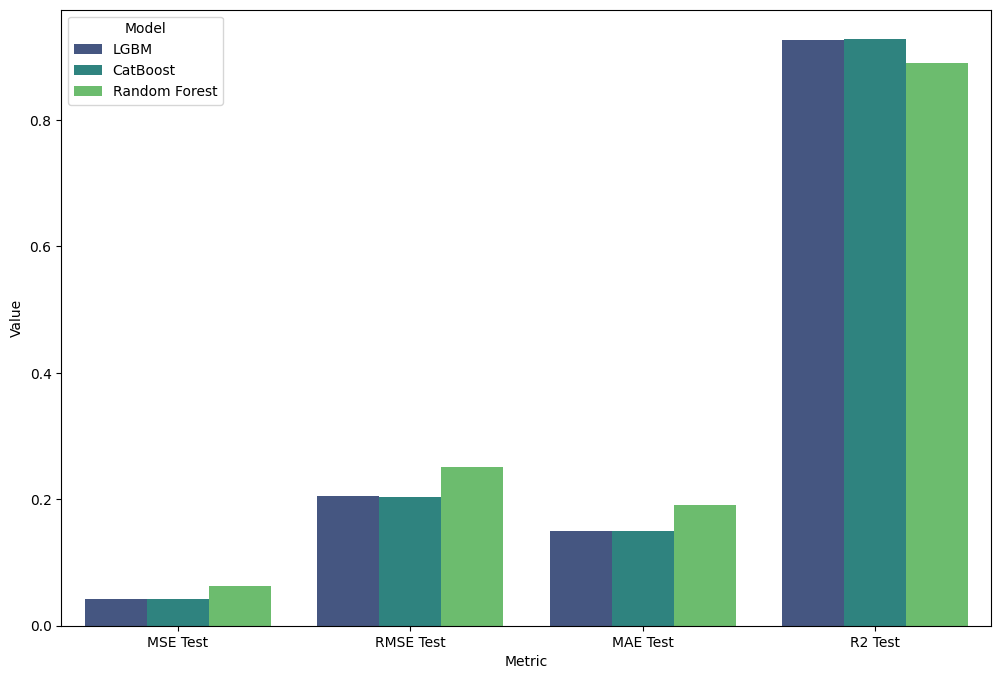

In [86]:
metrics = ['MSE Test', 'RMSE Test', 'MAE Test', 'R2 Test']
models = ['LGBM', 'CatBoost', 'Random Forest']

data = {
    'Model': [],
    'Metric': [],
    'Value': []
}

for i, model in enumerate(models):
    for j, metric in enumerate(metrics):
        data['Model'].append(model)
        data['Metric'].append(metric)
        if model == 'LGBM':
            data['Value'].append(metrics_lgbm[j])
        elif model == 'CatBoost':
            data['Value'].append(metrics_catboost[j])
        elif model == 'Random Forest':
            data['Value'].append(metrics_rforest[j])

df = pd.DataFrame(data)

plt.figure(figsize=(12, 8))

sns.barplot(x='Metric', y='Value', hue='Model', data=df, palette='viridis')
plt.show()


Модели показывают высокое качество, мне больше нравится модель LGBM


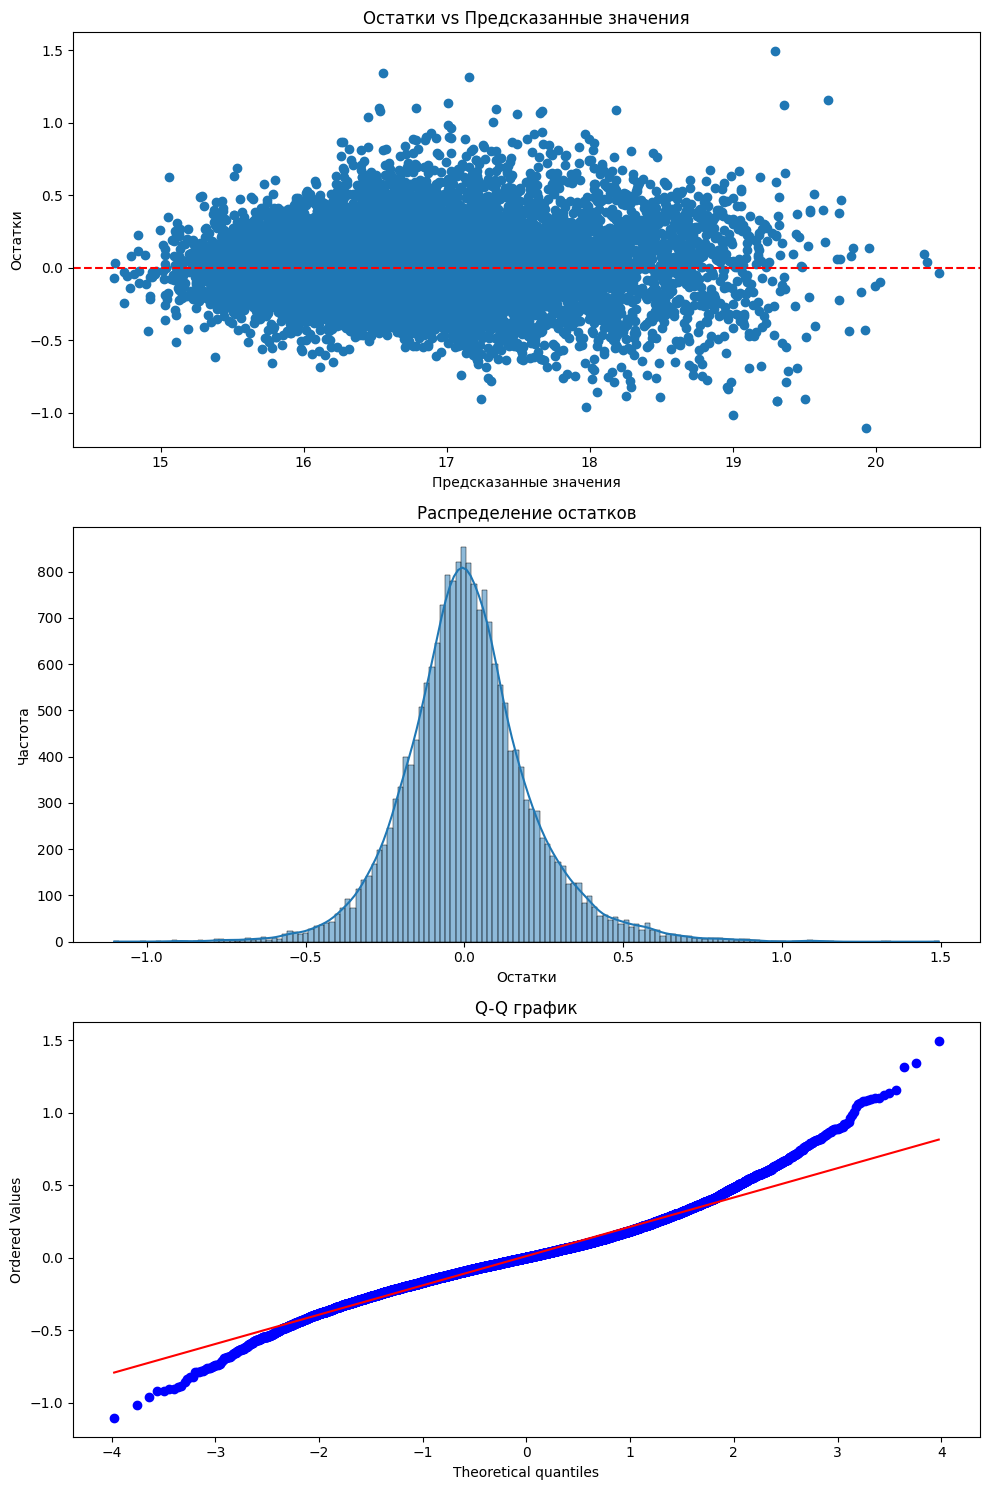

In [90]:
def plot_residuals(y_test, y_pred):
    residuals = y_test - y_pred

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))

    # График 1: Остатки vs Предсказанные значения
    ax1.scatter(y_pred, residuals)
    ax1.set_xlabel('Предсказанные значения')
    ax1.set_ylabel('Остатки')
    ax1.set_title('Остатки vs Предсказанные значения')
    ax1.axhline(y=0, color='r', linestyle='--')

    # График 2: Распределение остатков
    sns.histplot(residuals, kde=True, ax=ax2)
    ax2.set_xlabel('Остатки')
    ax2.set_ylabel('Частота')
    ax2.set_title('Распределение остатков')

    # График 3: Q-Q график
    stats.probplot(residuals, dist="norm", plot=ax3)
    ax3.set_title("Q-Q график")

    plt.tight_layout()
    plt.show()

# Посмотрим для последнего грид серча, какие остатки получились.
plot_residuals(y_test, y_pred)